# Initial analysis of OPS-SAT with Betsi

This is an initial analysis of OPS-SAT telemetry with Betsi, based on [Red's work analyzing BOBCAT-1 telemetry](https://gitlab.com/librespacefoundation/polaris/polaris-playground/-/blob/master/notebooks/betsi/Betsi%20Analysis%20-%20BOBCAT-1.ipynb).  (And by "based on", I mean "straight-up copy-pasta".)  It was originally done to get useful supporting information for [our proposal to run an experiment on OPS-SAT](https://gitlab.com/librespacefoundation/polaris/polaris/-/milestones/7).

There are a few shortcomings with the analysis done here:

- The date range was selected pretty much at random due to earlier problems analyzing the full range.
- The training run was shortened considerably in order to get results more quickly.
- The dates displayed in the figure are in odd order (December 19, then 25, then 24, then 23, then...); I haven't dug into this.
- The data was prepared using [a custom branch](https://gitlab.com/saintaardvark/polaris/-/tree/issue-169-handle-exceptions-fetching-spaceweather) of Polaris that dealt with [this bug](https://gitlab.com/librespacefoundation/polaris/polaris/-/issues/169) (which, as I write, is about to be addressed by [@deckbsd's merge request](https://gitlab.com/librespacefoundation/polaris/polaris/-/merge_requests/191)).

Further info will be given all all these points as we go on.

First, let's start with the usual imports and set a good figure size.

In [1]:
# workaround via specifying an invalid value first
# %config Application.log_level='WORKAROUND'
# => fails, necessary on Fedora 27, ipython3 6.2.1
# %config Application.log_level='DEBUG'
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from polaris.anomaly import detector

from betsi import models, preprocessors, predictors
import json
from sklearn.model_selection import train_test_split
from polaris.data.readers import read_polaris_data



In [2]:
# Plot configurations
plt.rcParams["figure.figsize"] = (25,8)

# Fetching/Loading Data with Polaris tools

The data for OPS-SAT was fetched using [this personal repo](https://gitlab.com/saintaardvark/opssat-analysis).  Details are in there, but here's a brief outline.

All the frames held by db.satnogs.org were downloaded in CSV format using the "Export all frames" button at https://db.satnogs.org/satellite/44878/.  (Note that you need to create an account there in order to see this option.)  For simplicity, that CSV file was mirrored on my personal website.

Using the Makefile in [my repo](https://gitlab.com/saintaardvark/opssat-analysis), I ran `make short`. This command:

- downloaded the mirror of the CSV file from my personal website;
- took the first 3000 lines and saved it to a separate file;
- ran `polaris fetch --import` on that file, which created a Polaris Dataset file named `opssat1-normalized_frames-short.json`.

It's that last file -- `opssat1-normalized_frames-short.json` -- that we'll be analyzing here.

In [3]:
!ls -l ../opssat-analysis/opssat1-normalized_frames-short.json

-rw-r--r--. 1 aardvark aardvark 32305844 May 18 20:32 ../opssat-analysis/opssat1-normalized_frames-short.json


In [4]:
M = read_polaris_data("../opssat-analysis/opssat1-normalized_frames-short.json")

# Using Betsi

## Selecting numerical and variable dataset

### Using polaris metadata

In [5]:
type(M[0])

polaris.dataset.metadata.PolarisMetadata

In [6]:
type(M[1])

pandas.core.frame.DataFrame

In [7]:
# Selection per polaris metadata information
column_selection = [c for c in M[0]["analysis"]["column_tags"] 
                    if M[0]["analysis"]["column_tags"][c] == "variable" ]


In [8]:
# In Red's original notebook, he was combining two separate dataframes, and `all_selection` combined
# `column_selection` and another variable called `column_selection2`.  That's not the case here, but
# I haven't yet had time to rewrite this.

all_selection = column_selection

### Concatenating data and removing all remaining non numerical columns

In [9]:
data = pd.concat([M[1][all_selection]])

In [10]:
# Overal check of all present variables types
all_types = [data[col].dtype for col in data.columns]
print("{} columns in M with types from (dtype('O') is Object):".format(len(all_types)))
print(np.unique(np.sort(all_types)))

36 columns in M with types from (dtype('O') is Object):
[dtype('float64')]


In [11]:
data.shape

(3204, 36)

In [12]:
all_numerical_cols = [col for col in all_selection 
                      if data[col].dtype  == "float64" or data[col].dtype == "int64"]
print(all_numerical_cols)

['board_temperature', 'pa_temperature', 'last_received_rssi', 'last_received_rf_error', 'number_of_tx_packets_since_reboot', 'number_of_rx_packets_since_reboot', 'number_of_tx_bytes_since_reboot', 'number_of_rx_bytes_since_reboot', 'active_system_configuration', 'reboot_number', 'reboot_cause', 'last_valid_packet_timestamp', 'background_rssi_level', 'tx_duty_time_since_reboot', 'total_tx_packets', 'total_rx_packets', 'total_tx_bytes', 'total_rx_bytes', 'College K 3-6', 'College K 18-21', 'College K 9-12', 'College K 6-9', 'College K 0-3', 'College K 15-18', 'College K 12-15', 'College K 21-24', 'College A', 'Proton 10 MeV', 'Electron 2 MeV', 'Proton 1 MeV', 'Electron 800 KeV', 'Proton 100 MeV', 'Sunspot Area', 'Radio Flux', 'X-ray Background Flux', 'time']


In [13]:
# Final data column selection

data = data[all_numerical_cols]
print(data.shape)
data.head(30)

(3204, 36)


board_temperature  pa_temperature  last_received_rssi  \
0                 NaN             NaN                 NaN   
1                 NaN             NaN                 NaN   
2                 NaN             NaN                 NaN   
3                 NaN             NaN                 NaN   
4                 NaN             NaN                 NaN   
5                 NaN             NaN                 NaN   
6                 NaN             NaN                 NaN   
7                 NaN             NaN                 NaN   
8                 NaN             NaN                 NaN   
9                 NaN             NaN                 NaN   
10                NaN             NaN                 NaN   
11                NaN             NaN                 NaN   
12                NaN             NaN                 NaN   
13                NaN             NaN                 NaN   
14                NaN             NaN                 NaN   
15                NaN             NaN                 NaN   
16                NaN             NaN                 NaN   
17                NaN             NaN                 NaN   
18                NaN             NaN                 NaN   
19                NaN             NaN                 NaN   
20                NaN             NaN                 NaN   
21                NaN             NaN                 NaN   
22                NaN             NaN                 NaN   
23                NaN             NaN                 NaN   
24                NaN             NaN                 NaN   
25                NaN             NaN                 NaN   
26                NaN             NaN                 NaN   
27                NaN             NaN                 NaN   
28                NaN             NaN                 NaN   
29                NaN             NaN                 NaN   

    last_received_rf_error  number_of_tx_packets_since_reboot  \
0                      NaN                                NaN   
1                      NaN                                NaN   
2                      NaN                                NaN   
3                      NaN                                NaN   
4                      NaN                                NaN   
5                      NaN                                NaN   
6                      NaN                                NaN   
7                      NaN                                NaN   
8                      NaN                                NaN   
9                      NaN                                NaN   
10                     NaN                                NaN   
11                     NaN                                NaN   
12                     NaN                                NaN   
13                     NaN                                NaN   
14                     NaN                                NaN   
15                     NaN                                NaN   
16                     NaN                                NaN   
17                     NaN                                NaN   
18                     NaN                                NaN   
19                     NaN                                NaN   
20                     NaN                                NaN   
21                     NaN                                NaN   
22                     NaN                                NaN   
23                     NaN                                NaN   
24                     NaN                                NaN   
25                     NaN                                NaN   
26                     NaN                                NaN   
27                     NaN                                NaN   
28                     NaN                                NaN   
29                     NaN                                NaN   

    number_of_rx_packets_since_reboot  number_of_tx_bytes_since_reboot  \
0                     

## Data preparation for the betsi auto-encoder based method

### Saving time index

In [14]:
# Keeping time index for later usage
time_index = pd.to_datetime(data.time, unit="s")
print(time_index.describe())

# Because data was built from 2 different dataframes.
time_index.index = range(time_index.shape[0])

count                    3204
unique                   2112
top       2019-12-18 17:33:00
freq                       12
first     2019-12-18 11:08:17
last      2019-12-25 17:32:52
Name: time, dtype: object


### Normalizing data for neural network input

In [15]:
print(data.isna().sum())
print("\n\t Although we have NaN we will imput them on the normalized data")

board_temperature                    245
pa_temperature                       245
last_received_rssi                   245
last_received_rf_error               245
number_of_tx_packets_since_reboot    245
number_of_rx_packets_since_reboot    245
number_of_tx_bytes_since_reboot      245
number_of_rx_bytes_since_reboot      245
active_system_configuration          245
reboot_number                        245
reboot_cause                         245
last_valid_packet_timestamp          245
background_rssi_level                245
tx_duty_time_since_reboot            245
total_tx_packets                     245
total_rx_packets                     245
total_tx_bytes                       245
total_rx_bytes                       245
College K 3-6                          0
College K 18-21                        0
College K 9-12                         0
College K 6-9                          0
College K 0-3                          0
College K 15-18                        0
College K 12-15 

In [16]:
# Step 1: Normalize the data
ndata, normalizer = preprocessors.normalize_all_data(data)

ndata = ndata.apply(lambda col: col.fillna(col.mean()),axis=0)

In [17]:
# Step 2: Convert it to columns using fixed stride and window size using Betsi preprocessor
window_size = 10
stride = 5
converted_data = preprocessors.convert_to_column(ndata, window_size=window_size, stride=stride)
print(converted_data.shape)

(640, 360)


In [18]:
# This should be zero here
converted_data.isna().sum().sum()

0

In [19]:
print("The input data {} has {} features all included and {} observations".format(ndata.shape, ndata.shape[1], ndata.shape[0]))
print("Window size is {}\nand stride is {}\n\t ==> thus generating a matrix for neural network input of size {}".format(window_size, stride, converted_data.shape))
print("\n\tFor info {}(observations)/{}(stride) = {}".format(ndata.shape[0], stride, ndata.shape[0]/stride))

The input data (3204, 36) has 36 features all included and 3204 observations
Window size is 10
and stride is 5
	 ==> thus generating a matrix for neural network input of size (640, 360)

	For info 3204(observations)/5(stride) = 640.8


## Neural Network settings

In [20]:
optimizer = "adam"
loss = "mean_squared_error"
metrics = "MSE"
layer_dims = [ converted_data.shape[1], 100, 30]
print(layer_dims)

[360, 100, 30]


In [21]:
# by Default layer activiations are ReLu
ae_model, en_model, de_model = models.custom_autoencoder(layer_dims) #, activations=activations)
# Compile the model for training
ae_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
en_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
de_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Fit and evaluate model

**Note:** Red's notebook originally trained for 1000 epochs.  As I was in a hurry, I went with just 50 in order to get quicker results.  As a result, the final model may not be as accurate as it could be.

In [22]:
train_data, test_data = train_test_split(
        converted_data,
        test_size=0.10, # usually 33% of data is for testing, 
        shuffle=False, # We disable shuffling since order matters (time)
    )

# You can also play around with the batch_size and epochs and enable
# early_stopping based on your needs
history = ae_model.fit(train_data, train_data, batch_size=32, epochs=50)

# To test the model to check if it has overfit, you can run:
ae_model.evaluate(test_data, test_data, batch_size=32)

Epoch 1/50
18/18 [==============================] - 0s 1ms/step - loss: 0.8552 - MSE: 0.8496
Epoch 2/50
18/18 [==============================] - 0s 1ms/step - loss: 0.7292 - MSE: 0.7210
Epoch 3/50
18/18 [==============================] - 0s 1ms/step - loss: 0.6490 - MSE: 0.6401
Epoch 4/50
18/18 [==============================] - 0s 1ms/step - loss: 0.6526 - MSE: 0.6431
Epoch 5/50
18/18 [==============================] - 0s 1ms/step - loss: 0.6456 - MSE: 0.6359
Epoch 6/50
18/18 [==============================] - 0s 1ms/step - loss: 0.5775 - MSE: 0.5682
Epoch 7/50
18/18 [==============================] - 0s 1ms/step - loss: 0.5634 - MSE: 0.5543
Epoch 8/50
18/18 [==============================] - 0s 1ms/step - loss: 0.5545 - MSE: 0.5457
Epoch 9/50
18/18 [==============================] - 0s 1ms/step - loss: 0.6444 - MSE: 0.6355
Epoch 10/50
18/18 [==============================] - 0s 1ms/step - loss: 0.5571 - MSE: 0.5486
Epoch 11/50
18/18 [==============================] - 0s 1ms/step - lo

[0.9493033289909363, 0.9358206987380981]

If you want to save the model, uncomment the following cell:

In [23]:
# ae_model.save('betsi-opssat')

In [24]:
train_data.shape

(576, 360)

## Running betsi analysis

### Predict and calculate feature-kernel distances 

In [25]:
# Step 1: Predict the "bottleneck" layer representation for the input data
data_rep = en_model.predict(converted_data)

# Step 2: Measure the distance between consecutive timestamps. This will be
# the metric to detect anomalies. Distance here refers to the L2 norm.
distance_list = []
for row_no in range(data_rep.shape[0] - 1):
    distance_list.append(
        predictors.distance_measure(data_rep[row_no], data_rep[row_no + 1]))

In [26]:
data_rep

array([[1.8169688 , 3.9815307 , 0.09173948, ..., 2.9269712 , 0.        ,
        1.565623  ],
       [1.8169948 , 3.981567  , 0.09175777, ..., 2.9269884 , 0.        ,
        1.5656186 ],
       [1.8169911 , 3.9815838 , 0.0917706 , ..., 2.9269967 , 0.        ,
        1.5656086 ],
       ...,
       [4.8604717 , 6.523988  , 1.9998707 , ..., 0.49886122, 0.57454693,
        3.8845904 ],
       [4.2226033 , 6.345993  , 2.1687655 , ..., 0.21950051, 0.22370167,
        3.554354  ],
       [1.8211766 , 4.171977  , 4.2083006 , ..., 0.7309185 , 0.        ,
        3.5657752 ]], dtype=float32)

In [27]:
distance_list

[9.480103239569482e-06,
 5.005765753595246e-06,
 2.1427202400478986e-05,
 1.4230485204599383e-05,
 0.06927110941071936,
 0.2530341745541214,
 0.1830642780290037,
 0.056371074044688455,
 0.03592419837375903,
 0.05106762918097594,
 0.03842607478477721,
 0.042477635831642074,
 0.014878964189715944,
 0.010272635289876337,
 0.030817979590656564,
 0.02073024991326917,
 0.023018341735088495,
 0.027698079589916026,
 0.031827308833429956,
 0.026835839221341775,
 0.01791805151156164,
 0.02259229124746436,
 0.02989720455658379,
 1.2531181440724994,
 0.7549113737818189,
 0.4575531673648267,
 0.48471312209549416,
 0.7998170002945617,
 1.3181663590017976,
 0.06586912290431597,
 0.17480690782802316,
 0.18702886975077926,
 0.1407144442663534,
 0.021123458790194217,
 0.038189465942155845,
 0.03700976444293851,
 0.020814842803295697,
 0.0987860482994841,
 0.10213054376024597,
 0.05217948660084631,
 0.08805327923718874,
 0.7433207656693919,
 0.7223499659677473,
 0.02618501901173274,
 0.06717082016664823,

In [28]:
my_array = np.array(distance_list)
my_array.shape, my_array.dtype, np.isnan(my_array).sum(), np.nanmean(my_array)

((639,), dtype('float64'), 0, 0.23239399847728423)

(640, 30)


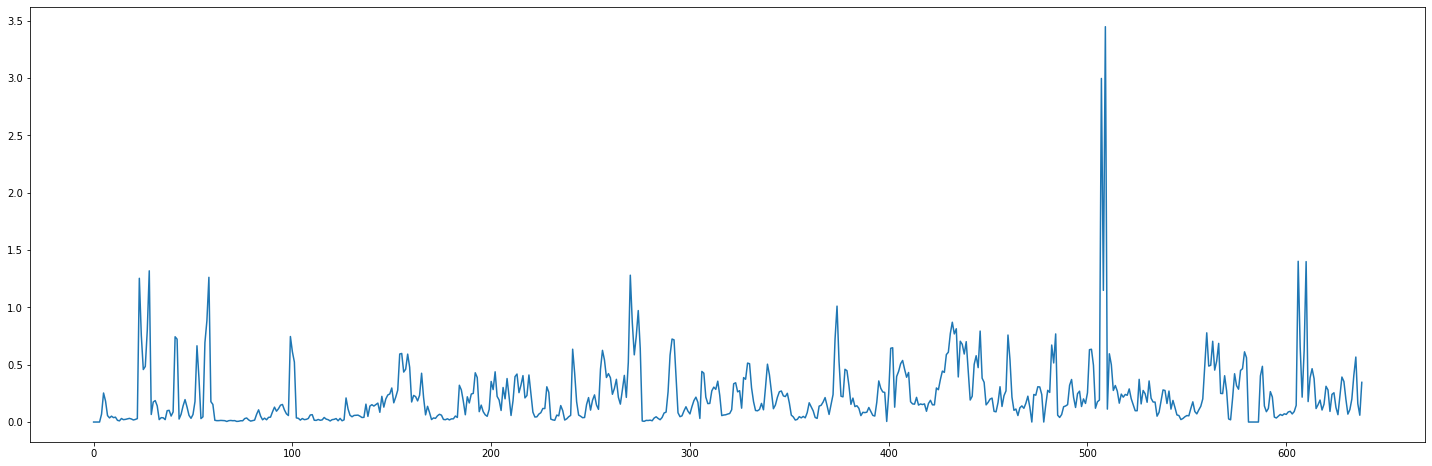

In [29]:
print(data_rep.shape)

plt.plot(distance_list)

In [30]:
# Step 3: Detect the events. We have a noise_margin_per variable to say
# how much (in percentage) should the value be above the average to be
# considered the event. Try playing around with this to find the best value!
noise_margin_per = 50 # 2.5 x the average ie 150% more than average
events = predictors.get_events(distance_list, threshold=noise_margin_per)

In [31]:
print("{} events detected with {}% average deviation".format(len(events), noise_margin_per))
print(events)

40 events detected with 50% average deviation
[28, 31, 46, 58, 64, 105, 155, 158, 249, 259, 274, 278, 298, 312, 323, 336, 346, 374, 378, 382, 402, 407, 410, 432, 434, 439, 444, 452, 464, 492, 507, 509, 511, 514, 563, 566, 579, 610, 613, 635]


### Plot events on the data

In [32]:
#df_test = pd.read_pickle("/tmp/test_data.pkl")

# df_test = pd.read_pickle("/tmp/test_data.pkl")
# events = json.load(open("/tmp/anomaly_metrics.json"))["events"]

In [33]:
# events by order of breakage (difference with previous behavior) in DESC order (biggest first)
sorted_dist = np.argsort(distance_list)[::-1]
events_sorted = [evt for evt in sorted_dist if evt in events]

In [34]:
events_sorted

[509,
 507,
 610,
 28,
 58,
 374,
 274,
 432,
 434,
 563,
 439,
 566,
 402,
 579,
 155,
 511,
 158,
 444,
 635,
 407,
 613,
 378,
 410,
 259,
 492,
 323,
 514,
 312,
 346,
 249,
 382,
 452,
 46,
 31,
 336,
 298,
 464,
 105,
 278,
 64]

In [35]:
print(distance_list[604])
print(distance_list[360])

0.09134760700063711
0.16790807266572394


# A note on the plot

Originally, Red's notebook analyzing BOBCAT-1 focused on a particular date where the operators had told us that behaviour began changing.  As such, the code he wrote in the next cell focused on that particular date.  I've tried to clean that up here, but may not have caught everything.

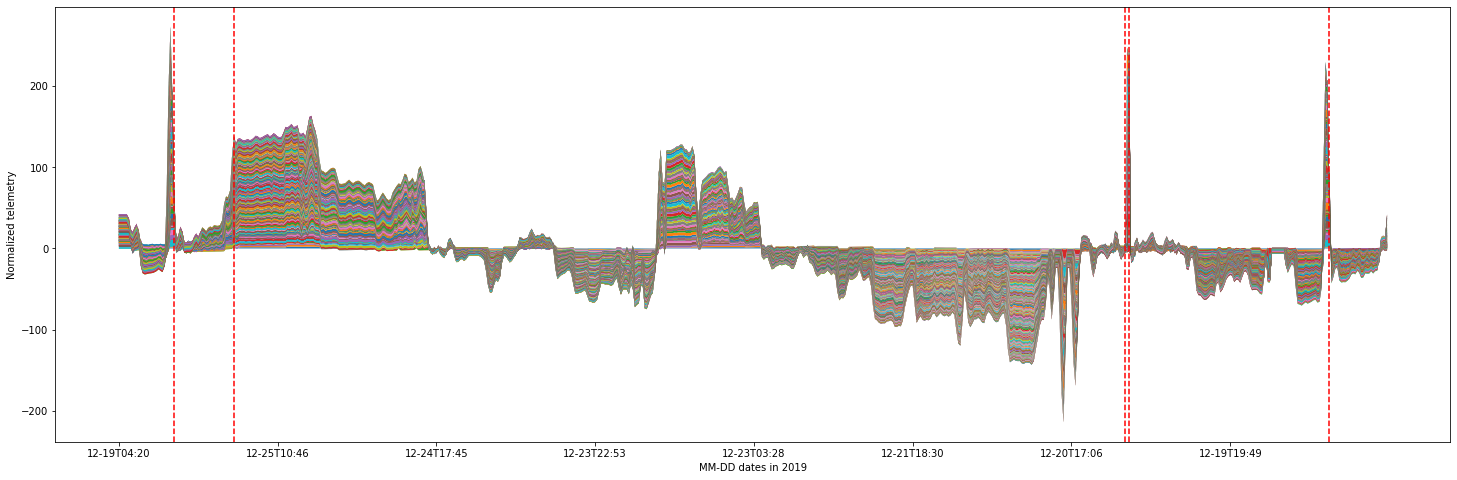

<Figure size 1800x576 with 0 Axes>

In [36]:
plt.close()

ndf = converted_data.to_numpy()

# Time index with one point every stride
ndf_time = (time_index.iloc[::stride]).iloc[:-1]

# To remove columns of data which are constant
#ndf[:, ~np.all(ndf[1:] == ndf[:-1], axis=0)]

# tot_cols = ndf.shape[1] # Not used
tot_rows = ndf.shape[0]

# Creating the stack plot
plt.stackplot(range(ndf.shape[0]), ndf.T)
#plt.stackplot(ndf_time.to_numpy().T, ndf.T)


# 
# Note: this made the plot a little busy, so I commented it out.
# Hugh, May 29 2021
#
# Plotting the events on top of the stackplots as dotted lines
# for xc in events:
#    if xc > tot_rows:
#        # Just a fail-safe, made some mistakes before
#        break
#    #plt.axvline(ndf_time.iloc[xc], color="k", linestyle="--")
#    plt.axvline(xc, color="k", linestyle="--")

#
# Note : 5 was picked arbitrarily, but seems to work well enough to illustrate 
# how Betsi works.
# Hugh, May 29, 2021
# 
# Plotting in red the 5 biggest changes
for xc in events_sorted[:5]:
    if xc > tot_rows:
        # Just a fail-safe, made some mistakes before
        break
    #plt.axvline(ndf_time.iloc[xc], color="k", linestyle="--")
    plt.axvline(xc, color="r", linestyle="--")

At = list(range(ndf.shape[0])[::80])
At_time_str = [str(d)[5:16] for d in ndf_time.to_numpy()[At]]

plt.xticks(At, At_time_str)

# Note: I examined the JSON frames file manually to verify the year.
# Hugh, May 29, 2021
plt.xlabel("MM-DD dates in 2019")
plt.ylabel("Normalized telemetry")
plt.show()
plt.savefig("ttttt.png")

# ndf.shape[0]

# This ends the OPSSAT analysis

This is as far as I went executing cells for OPSSAT.  The code that follows may work, but was part of the original analysis of Bobcat.  My purpose was generating the figure above, so I haven't tried running what follows; YMMV.


### Brownbag analysis

In [ ]:
ndf_time.iloc[378]

In [ ]:
ndf_time.iloc[360]

In [ ]:
# Trying to see how much apart the betsi breakpoint (first datetime) is from information from operators (second datetime)
time_index[(time_index > '2021-04-24 15:38:14') & (time_index <= '2021-04-25 05:20:43')]

In [ ]:
def plot_events_against_real_telemetry(df, events_timestamps=None, savefig="/tmp/hhh.svg"):
    """ Tailored for a dataframe df that has a time column
    """
    plt.close()
    time_idx = pd.to_datetime(df.time, unit="s")
    # In case the time_idx has a wrong numbering
    time_idx.index = range(time_idx.shape[0])
    df.index = time_idx
    
    #plt.stackplot(range(df.shape[0]), df.T)
    normalized_df=(df-df.min())/(df.max()-df.min())
    #print(normalized_df.head())
    plt.plot(normalized_df, "ko", alpha=0.05)
    
    if events_timestamps is not None:
        for evt in events_timestamps:
            plt.axvline(evt, color="r", linestyle="--", linewidth="4", alpha=0.7)
            print(evt)
            
    plt.axvline('2021-04-25 05:20:43', color="c", linestyle="--", linewidth="4", alpha=0.9)
    plt.xlabel("Timestamp")
    plt.ylabel("Normalized telemetry")
    
    plt.savefig(savefig)
    
    plt.show()
    print()

In [ ]:
plot_events_against_real_telemetry(data, ndf_time.iloc[events])

In [ ]:
# The window time of window_size
time_index[window_size] - time_index[0] 

In [ ]:
def extract_datasets_around_event(df, timeref, events_list, event_index=10, base_name="../data/bobcat-1-behavior-data"):
    D1 = df[(df.index > timeref.iloc[events_list[event_index-1]]) & (df.index <= timeref.iloc[events_list[event_index]])]
    D2 = df[(df.index > timeref.iloc[events_list[event_index]]) & (df.index <= timeref.iloc[events_list[event_index+1]])]
    print("Two datasets around {}".format(timeref.iloc[events_list[event_index]]))
    D1.to_csv(base_name+"-B1.csv")
    D2.to_csv(base_name+"-B2.csv")
    

In [ ]:
ndf_time.iloc[events[9]]

In [ ]:
extract_datasets_around_event(data, ndf_time, events, 10)

In [ ]:
extract_datasets_around_event(data, ndf_time, events, 9, base_name="../data/bobcat-1-behavior-around-2021-04-12")

## Comparing graphs of two consecutive behavior periods

In [ ]:
graph_before = "../data/bobcat-1-behavior-around-2021-04-12-BEFORE.json"
graph_after  = "../data/bobcat-1-behavior-around-2021-04-12-AFTER.json"
graph_after_after  = "../data/bobcat-1-behavior-around-2021-04-12-AFTER-AFTER.json"

In [ ]:
def compare_two_graphs(gbefore, gafter):
    with open(gbefore, "r") as fff:
        json_before = json.load(fff)
    
    with open(gafter, "r") as fff:
        json_after = json.load(fff)
        
    for node in json_after["graph"]["nodes"]:
        if node not in json_before["graph"]["nodes"]:
            print("missing node from before: "+node)
                 
    for node in json_before["graph"]["nodes"]:
        if node not in json_after["graph"]["nodes"]:
            print("missing node from after: "+node)
            
    #uniqsrc = np.uniq([elt["source"] for elt in json_after["graph"]["links"]])
    
    def build_link_db(graph):
        db = {}
        for elt in graph["graph"]["links"]:
            if elt["source"] not in db:
                db[elt["source"]] = {}
            db[elt["source"]][elt["target"]] = elt["value"]
        return db
    
    after_db = build_link_db(json_after)
    before_db = build_link_db(json_before)
    for src in after_db:
        if src in before_db:
            for target in after_db[src]:
                if target in before_db[src]:
                    A = after_db[src][target]
                    B = before_db[src][target]
                    adiff = np.abs(A-B)
                    if adiff > 0.0:
                        if A > B:
                            A = B
                        if A/adiff > 0.2:
                            print("Consequent change on pair {} --> {} = from {} to {} ".format(
                                  src, target, before_db[src][target], after_db[src][target]))
                else:
                    print("New pair from already existing source {} --> {} = {} ".format(src, target, after_db[src][target]))
        else:
            print("No links were present before from that paramater:   "+src)
            for target in after_db[src]:
                print("\t--> "+target)

In [ ]:
compare_two_graphs(graph_before, graph_after)

In [ ]:
compare_two_graphs(graph_after, graph_after_after)

In [ ]:
compare_two_graphs(graph_before, graph_after_after)